#### Denoising Autoencoder

Sticking with the MNIST dataset, let's add noise to our data and see if we can define and train an autoencoder to _de_-noise the images.

Let's get started by importing our libraries and getting the dataset.

In [4]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
from pathlib import Path
import sys
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
# from helpers import get_data_loaders
# from helpers import seed_all
# from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
# seed_all(42)

np.random.seed(42)  

project_root_path = str(Path.cwd().parent)

if project_root_path not in sys.path:
    sys.path.insert(0, project_root_path)
    print(f"Added to sys.path: {project_root_path}")

from src.data import get_data_loaders

Added to sys.path: /Users/chaklader/Documents/Education/Udacity/Deep_Learning/Projects/2_landmark-classification-cnn


In [5]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=20)

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])


/Users/chaklader/Documents/Education/Udacity/Deep_Learning/Projects/2_landmark-classification-cnn/src/helpers.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch

### Visualize the Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7458944..0.8969897].


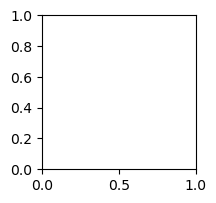

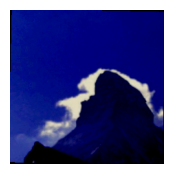

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)

# Convert to numpy and select first image
img = images[0].numpy()  # Convert PyTorch tensor to NumPy array
img = img.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)

# If the image is normalized, you might need to denormalize it
# img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
# img = np.clip(img, 0, 1)

# Plot the image
fig, sub = plt.subplots(figsize=(2, 2)) 
sub.imshow(img)
sub.axis("off")
plt.show()

#### Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practice. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets.

Below is an example of some of the noisy images I generated and the associated, denoised images.

Below you will write a convolutional autoencoder. Given the difficulty of the task, you might want to go deeper than what we used in the other exercises in this lesson.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 16, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 32, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        self.model = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
                
        return self.model(x)


# initialize the NN
model = ConvDenoiser()

---
## Training

>In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

First let's specify the loss and the optimizer:

In [6]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

And now let's train:

In [ ]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in tqdm(
        desc="Training", 
        total=len(data_loaders['train']), 
        iterable=data_loaders['train'],
        ncols=80
    ):
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        if torch.cuda.is_available():
            images = images.cuda()
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.rand_like(images)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid'],
        ncols=80):
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data

            if torch.cuda.is_available():
                images = images.cuda()

            ## add random noise to the input images
            noisy_imgs = images + noise_factor * torch.rand_like(images)
            # Clip the images to be between 0 and 1
            noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
            
            ## forward pass: compute predicted outputs by passing *noisy* images to the model
            outputs = model(noisy_imgs)
            # calculate the loss
            # the "target" is still the original, not-noisy images
            loss = criterion(outputs, images)

            # update running training loss
            val_loss += loss.item()*images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'].dataset)
    val_loss /= len(data_loaders['valid'].dataset)
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|████████████████████████████| 600/600 [00:01<00:00, 333.41it/s]


Epoch: 1 	Training Loss: 0.569252	Valid Loss: 0.363749


Training:  52%|██████████████▍             | 1240/2400 [00:06<00:06, 191.37it/s]

## Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

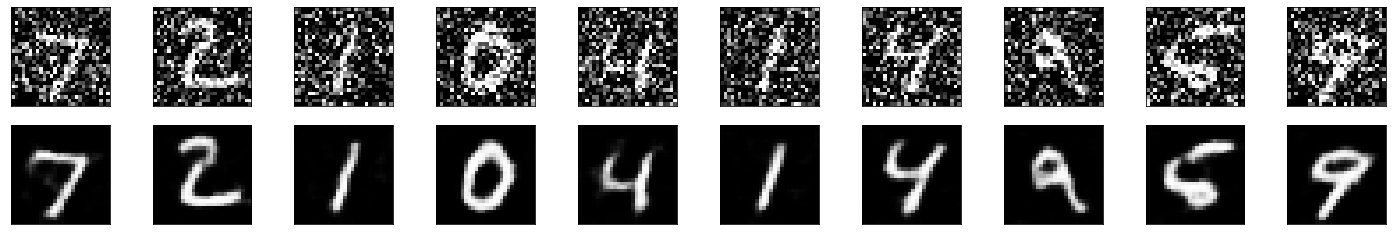

In [12]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + 0.5 * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(20, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)